In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.model_fpgan import FPGANSynthesizer
from models.model_ctgan import CTGANSynthesizer
from models.model_dpctgan import DPCTGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity, get_accuracy, get_roc_auc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("D:/Datasets/lung/data.csv")
data = data.drop(columns=['index','Patient Id'])

data.Level = data.Level.replace("Low", 0)
data.Level = data.Level.replace("Medium", 0)
data.Level = data.Level.replace("High", 1)

data.Level = data.Level.astype("int64")

data.head()

,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,33,1,2,4,5,4,3,2,2,4,...,3,4,2,2,3,1,2,3,4,0
1,17,1,3,1,5,3,4,2,2,2,...,1,3,7,8,6,2,1,7,2,0
2,35,1,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,1
3,37,1,7,7,7,7,6,7,7,7,...,4,2,3,1,4,5,6,7,5,1
4,46,1,6,8,7,7,7,6,7,7,...,3,2,4,1,4,2,4,2,3,1


In [4]:
data.shape

(1000, 24)

In [5]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())

In [6]:
target = 'Level'

In [7]:
X = data.drop(columns=[target])
y = data[target]

In [8]:
#model_ctgan = CTGANSynthesizer(epochs=200, verbose=True)
#model_ctgan = DPCTGANSynthesizer(verbose=True)
model_ctgan = FPGANSynthesizer(epochs=200, verbose=True)
#original_losses, tranformed_privacies, losses = model_ctgan.fit(data)
model_ctgan.fit(data,rate=0.25)

Epoch 1, Loss G: -0.3126,Loss D: -0.0007
Epoch 2, Loss G: -0.3146,Loss D: -0.0359
Epoch 3, Loss G: -0.3158,Loss D: -0.1668
Epoch 4, Loss G: -0.3141,Loss D: -0.2408
Epoch 5, Loss G: -0.3075,Loss D: -0.4911
Epoch 6, Loss G: -0.2957,Loss D: -0.7600
Epoch 7, Loss G: -0.2802,Loss D: -1.1303
Epoch 8, Loss G: -0.2705,Loss D: -1.5146
Epoch 9, Loss G: -0.2782,Loss D: -1.4843
Epoch 10, Loss G: -0.3097,Loss D: -1.2514
Epoch 11, Loss G: -0.3556,Loss D: -0.5234
Epoch 12, Loss G: -0.4000,Loss D:  0.0322
Epoch 13, Loss G: -0.4224,Loss D:  0.6617
Epoch 14, Loss G: -0.4448,Loss D:  0.5483
Epoch 15, Loss G: -0.4549,Loss D:  0.4175
Epoch 16, Loss G: -0.4507,Loss D:  0.3605
Epoch 17, Loss G: -0.4505,Loss D:  0.1611
Epoch 18, Loss G: -0.4386,Loss D:  0.1644
Epoch 19, Loss G: -0.4319,Loss D: -0.2745
Epoch 20, Loss G: -0.4183,Loss D: -0.3759
Epoch 21, Loss G: -0.4089,Loss D: -0.8022
Epoch 22, Loss G: -0.3876,Loss D: -0.5736
Epoch 23, Loss G: -0.3792,Loss D: -0.9130
Epoch 24, Loss G: -0.3793,Loss D: -1.0523
E

([array(0.00716537, dtype=float32),
  array(0.01314777, dtype=float32),
  array(0.01632786, dtype=float32),
  array(0.01772563, dtype=float32),
  array(0.02533552, dtype=float32),
  array(0.03170167, dtype=float32),
  array(0.04089875, dtype=float32),
  array(0.05363955, dtype=float32),
  array(0.07737111, dtype=float32),
  array(0.0962706, dtype=float32),
  array(0.11981829, dtype=float32),
  array(0.14814188, dtype=float32),
  array(0.18694611, dtype=float32),
  array(0.21023907, dtype=float32),
  array(0.21881491, dtype=float32),
  array(0.23582946, dtype=float32),
  array(0.22738792, dtype=float32),
  array(0.18568857, dtype=float32),
  array(0.12447405, dtype=float32),
  array(0.0462834, dtype=float32),
  array(-0.03399564, dtype=float32),
  array(-0.15176821, dtype=float32),
  array(-0.23723844, dtype=float32),
  array(-0.3263817, dtype=float32),
  array(-0.37386805, dtype=float32),
  array(-0.4118031, dtype=float32),
  array(-0.47657347, dtype=float32),
  array(-0.48963508, dtyp

In [9]:
from utils.utils import save_models
save_models(model_ctgan, '25fpgan200', 'lung')

In [10]:
from utils.utils import load_models
model_ctgan = load_models('25fpgan200', 'lung')

In [11]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [12]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame
samples = samples[:2000]
data = data[:2000]

In [13]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.34288266]


## Fidelity

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42, stratify=y_syn)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test, undersample=False)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test, undersample=False)

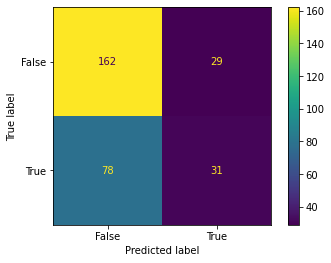

In [15]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [16]:
percentage = eval_fidelity(rr_pred, fr_pred)

In [17]:
rr_acc = get_accuracy(y_test, rr_pred)
fr_acc = get_accuracy(y_test, fr_pred)
print("Accuracy of real data: ", rr_acc)
print("Accuracy of synthetic data: ", fr_acc)

Accuracy of real data:  1.0
Accuracy of synthetic data:  0.6433333333333333


In [18]:
rr_score = get_roc_auc(y_test, rr_pred)
fr_score = get_roc_auc(y_test, fr_pred)
print("ROC AUC of real data: ", rr_score)
print("ROC AUC of synthetic data: ", fr_score)

ROC AUC of real data:  1.0
ROC AUC of synthetic data:  0.5662856044958932


## Final plot

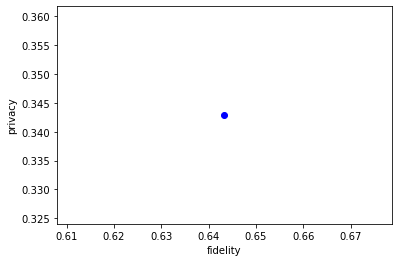

0.6433333333333333 [0.34288266]


In [19]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()
print(percentage, normalized_avg_distance)